In [ ]:
!git clone https://github.com/oreilly-japan/deep-learning-from-scratch

Cloning into 'deep-learning-from-scratch'...
remote: Enumerating objects: 457, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 457 (delta 0), reused 1 (delta 0), pack-reused 453
Receiving objects: 100% (457/457), 5.52 MiB | 32.48 MiB/s, done.
Resolving deltas: 100% (235/235), done.


In [ ]:
cd deep-learning-from-scratch

/content/deep-learning-from-scratch


In [ ]:
import os
path = '/content/deep-learning-from-scratch/'

#作業ディレクトリをpathに移動する
os.chdir(path)

#作業ディレクトリ直下のファイルを確認
!ls

ch01  ch03  ch05  ch07	common	 LICENSE.md
ch02  ch04  ch06  ch08	dataset  README.md


# CNNの実装


## 引数

- input_dim ―― 入力データの (チャンネル, 高さ, 幅) の次元
- conv_param ―― 畳み込み層のハイパーパラメータ(ディクショナリ)。ディクショナリのキーは下記のとおり
  -   filter_num ―― フィルターの数 

  -  filter_size ―― フィルターのサイズ

  -  stride ―― ストライド 

  -  pad ―― パディング 
- hidden_size ―― 隠れ層(全結合)のニューロンの数
- output_size ―― 出力層(全結合)のニューロンの数
- weight_init_std ―― 初期化の際の重みの標準偏差

In [ ]:
import numpy as np
np.random.randn(3)

array([-1.76991189,  0.42223995,  1.39515593])

In [ ]:
# import sys, os
# sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """単純なConvNet
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    """
    # 初期化の引数で与えられた畳み込み層のハイパーパラメータをディクショナリから取り出す
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 重みを初期化する
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）
        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）
        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

ストリーミング出力は最後の 5000 行に切り捨てられました。
train loss:0.0012331093779449373
train loss:0.007370345726627417
train loss:0.0039178833514828745
train loss:0.0267568621843611
train loss:0.009053346986791387
train loss:0.016018785117257173
train loss:0.0009170532338917251
train loss:0.0015166023817597249
train loss:0.046730592907638514
train loss:0.0011057077305227589
train loss:0.04301606360093997
train loss:0.0033626332913440286
train loss:0.04050959049732371
train loss:0.005341489926429457
train loss:0.0012021030241936021
train loss:0.003326777743582471
train loss:0.010356978193399917
train loss:0.007113240996837686
train loss:0.013871596777268479
train loss:0.003551607198334593
train loss:0.007152071223840447
train loss:0.0015320480638213907
train loss:0.01430147398374579
train loss:0.009118128862947187
train loss:0.002207596209232486
train loss:0.0014109311409901733
train loss:0.00010022415156891701
train loss:0.0017999764501213736
train loss:0.0014454851874750698
train loss:0.004794086511746903


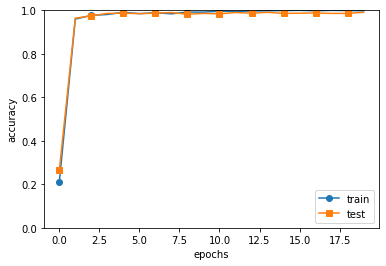

Computation time:3376.879 sec


In [ ]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
# from simple_convnet import SimpleConvNet
from common.trainer import Trainer
import time


# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)


# 処理に時間のかかる場合はデータを削減 
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]


max_epochs = 20

#処理を始めた時間
start_time = time.time()


network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()


# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")


# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
print('Computation time:{0:.3f} sec'.format(time.time() - start_time))

# 7.6 章CNNの可視化
## 7.6.1 1層目の重みの可視化
- 4次元配列（データ数, チャネル数, 高さ, 幅)

MNISTデータセットでの1層目の重みは(30,1,5,5)

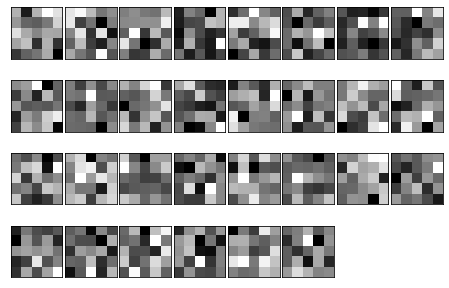

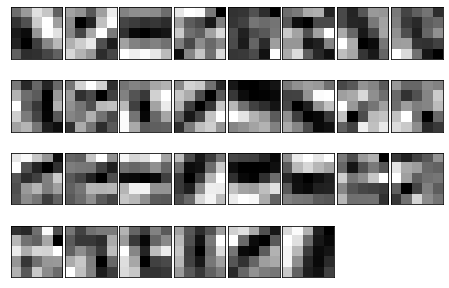

In [ ]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
# from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# ランダム初期化後の重み
filter_show(network.params['W1'])

# 学習後の重み
network.load_params("params.pkl")
filter_show(network.params['W1'])

# 番外編

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils

In [ ]:
#mnistデータをロード
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train = X_train.reshape((60000, 28, 28, 1))
#X_testの形状を(10000, 28, 28)から(10000, 28, 28, 1)に変更
X_test = X_test.reshape((10000, 28, 28, 1))

#データの型をfloat32に変える
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

#データの正規化(0から255までのデータを0から1までのデータにする)
X_train = X_train / 255
X_test = X_test / 255

#one-hotエンコーディング
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

- https://keras.io/ja/layers/convolutional/#conv2d
- https://qiita.com/kenichiro-yamato/items/60affeb7ca9f67c87a17



In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(28, 28, 1), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 10)                1

In [ ]:
#モデルのコンパイル
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics='accuracy')

In [ ]:
#モデルの訓練
model.fit(X_train, y_train, batch_size=128, epochs=20, validation_split=0.2)

Epoch 1/20
375/375 [==============================] - 11s 6ms/step - loss: 0.3218 - accuracy: 0.9106 - val_loss: 0.1055 - val_accuracy: 0.9703
Epoch 2/20
375/375 [==============================] - 2s 5ms/step - loss: 0.0840 - accuracy: 0.9744 - val_loss: 0.0786 - val_accuracy: 0.9744
Epoch 3/20
375/375 [==============================] - 2s 5ms/step - loss: 0.0615 - accuracy: 0.9812 - val_loss: 0.0596 - val_accuracy: 0.9833
Epoch 4/20
375/375 [==============================] - 2s 5ms/step - loss: 0.0510 - accuracy: 0.9844 - val_loss: 0.0532 - val_accuracy: 0.9841
Epoch 5/20
375/375 [==============================] - 2s 5ms/step - loss: 0.0421 - accuracy: 0.9873 - val_loss: 0.0507 - val_accuracy: 0.9848
Epoch 6/20
375/375 [==============================] - 2s 5ms/step - loss: 0.0384 - accuracy: 0.9878 - val_loss: 0.0429 - val_accuracy: 0.9873
Epoch 7/20
375/375 [==============================] - 2s 5ms/step - loss: 0.0319 - accuracy: 0.9899 - val_loss: 0.0465 - val_accuracy: 0.9865
Epoch

In [ ]:
print('\n<Evaluate>')
score = model.evaluate(X_test, y_test)

print("test loss score : ", score[0])
print("test accuracy : ", score[1])


<Evaluate>
313/313 [==============================] - 1s 3ms/step - loss: 0.0422 - accuracy: 0.9891
test loss score :  0.04224003478884697
test accuracy :  0.9890999794006348


https://miurabo.com/keras-mnist-cnn/

41秒で実装